In [11]:
# import basic libraries
import pickle
import yt
import numpy as np
import matplotlib.pyplot as plt
from math import log, log10, pi
from astropy import units as u

# import halo catalogue func
from yt.analysis_modules.halo_analysis.api import *

In [12]:
# import libraries - not sure what they do
# used to ensure halo catalog loads properly
import tempfile
import shutil
import os

# Create temporary directory for storing files
tmpdir = tempfile.mkdtemp()

In [258]:
# load halo dataset
halos_ds = yt.load('./LG4_2048_40pc/rd0030/halo_catalogs/catalog/catalog.0.h5')

# load raw dataset
ds = yt.load('~/../../tigress/cen/LG4_2048_40pc/RD0070/redshift0070')

# Instantiate a catalog using those two paramter files
hc = HaloCatalog(halos_ds=halos_ds, output_dir=os.path.join(tmpdir, 'halo_catalog'))
hc.load()

yt : [INFO     ] 2017-07-27 11:41:25,748 Parameters: current_time              = 2.442094332e+16
yt : [INFO     ] 2017-07-27 11:41:25,750 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2017-07-27 11:41:25,753 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-07-27 11:41:25,755 Parameters: domain_right_edge         = [  1.66901647e+25   1.66901647e+25   1.66901647e+25]
yt : [INFO     ] 2017-07-27 11:41:25,758 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2017-07-27 11:41:25,760 Parameters: current_redshift          = 6.99999981444
yt : [INFO     ] 2017-07-27 11:41:25,761 Parameters: omega_lambda              = 0.712
yt : [INFO     ] 2017-07-27 11:41:25,763 Parameters: omega_matter              = 0.288
yt : [INFO     ] 2017-07-27 11:41:25,765 Parameters: hubble_constant           = 0.6933
yt : [INFO     ] 2017-07-27 11:41:25,884 Parameters: current_time              = 158.01757996843
yt : [INFO     ] 2017-07-27 11:41:25,886 Paramet

In [13]:
redshift_filename = './LG4_2048_40pc/rd0070/redshift0070'

# load redshift and Omega values from parameter file
with open(redshift_filename, 'rt') as param_file:
    param_contents = param_file.read()
    
    #redshift
    cindex1 = param_contents.find('CosmologyCurrentRedshift')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    redshift = float(param_contents[cindex_eq+2:cindex2])
    
    # omega_m
    cindex1 = param_contents.find('CosmologyOmegaMatterNow')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    omega_m = float(param_contents[cindex_eq+2:cindex2])
    
    # hubble const now
    cindex1 = param_contents.find('CosmologyHubbleConstantNow')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    hubb_now = float(param_contents[cindex_eq+2:cindex2]) *(u.km / u.s / u.Mpc) 
    
    # cosmological constant
    cindex1 = param_contents.find('CosmologyOmegaLambdaNow')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    cos_const = float(param_contents[cindex_eq+2:cindex2])
    
    # omega baryon as specified by Renyue
    omega_b = 0.048
    
    # box size
    cindex1 = param_contents.find('CosmologyComovingBoxSize')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    box_size = float(param_contents[cindex_eq+2:cindex2]) * u.Mpc
    
    # left edge strings
    cindex1 = param_contents.find('RefineRegionLeftEdge')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    left_edge_string = param_contents[cindex_eq+2:cindex2]
    left_edges = left_edge_string.split()
    
    # right edge strings
    cindex1 = param_contents.find('RefineRegionRightEdge')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    right_edge_string = param_contents[cindex_eq+2:cindex2]
    right_edges = right_edge_string.split()
    
# calculate hubble const for simulation
hubb_z = (100* hubb_now.to('s**-1')) * ((omega_m * (1 + redshift)**3) + (1 - omega_m))**0.5

# calculate crit density and threshold
GRAV_CONST = (6.67408e-11 * u.m**3 /(u.kg * u.s**2)).to('cm^3*g^-1*s^-2')
crit_dens = (3 * hubb_z**2) / (8 * pi * GRAV_CONST)
omegas = (1 - (omega_b / omega_m))
threshold = 200 * omegas * crit_dens

# min and max bounds for radial profile
# min = 1 kpc proper
# max = 0.5 Mpc comoving
# convert to centimeters value (without astropy units)
rad_min = 1 * u.kpc
rad_max = 0.5 * u.Mpc
rad_max = rad_max / (1 + redshift) # convert to physical

# specify boundaries of zoom-in box
# scaling factor multiplied by info from text file 
# units in cm
scaling =  ((box_size / hubb_now.value) / (1 + redshift)).to('kpc') # size of box
xmin = scaling*float(left_edges[0])
ymin = scaling*float(left_edges[1])
zmin = scaling*float(left_edges[2])
xmax = scaling*float(right_edges[0])
ymax = scaling*float(right_edges[1])
zmax = scaling*float(right_edges[2])

In [244]:
# --load ratio of stellar mass to halo mass
# first list uses first output of TotalMass funct
# second list uses second output

with open('./LG4_2048_40pc/rd0070/ratio_list0070_1.txt', 'rb') as ratiofile1:
    ratiolist1 = pickle.load(ratiofile1)
    
with open('./LG4_2048_40pc/rd0070/ratio_list0070_2.txt', 'rb') as ratiofile2:
    ratiolist2 = pickle.load(ratiofile2)
    
# load master calc list for LG35
with open('./LG4_2048_40pc/rd0070/calc_list0070_2000', 'rb') as infile:
    halo_list = pickle.load(infile)

In [245]:
halo_list

[[0,
  9177,
  <Quantity 3305.8262831755724 kpc>,
  <Quantity 3322.761866996849 kpc>,
  <Quantity 3961.388738873247 kpc>,
  <Quantity 9436427.737566702 solMass>,
  <Quantity 25690420805.269367 solMass>,
  <Quantity 1.1031248364397543 kpc>,
  <Quantity 26.775585438851632 kpc>,
  1090,
  0,
  0,
  0,
  0,
  0],
 [1,
  9176,
  <Quantity 3471.321237540266 kpc>,
  <Quantity 3401.079827252028 kpc>,
  <Quantity 3400.2140118338907 kpc>,
  <Quantity 15366540497.776512 solMass>,
  <Quantity 11922229400.652966 solMass>,
  <Quantity 12.978190902719229 kpc>,
  <Quantity 17.092227807976773 kpc>,
  -1,
  <Quantity 1282781352.449772 solMass>,
  <Quantity 1032332655.8215156 solMass>,
  <Quantity 8409418400841380.0 s>,
  2.305267295890719,
  <Quantity 0.7361387080030471 kpc>],
 [2,
  9174,
  <Quantity 3234.5723431601455 kpc>,
  <Quantity 3238.272559181017 kpc>,
  <Quantity 3936.3089287070466 kpc>,
  <Quantity 14136653493.151896 solMass>,
  <Quantity 11434599641.2193 solMass>,
  <Quantity 12.622275668102

In [231]:
min_mass = 1e10 * u.Msun
mindex = 0

toSkip = (697, 825, 902, 914, 1111, 1211, 556)

count_agezero = 0
count_stelzero = 0
for halo in halo_list:
    mass = halo[5]
    rad = halo[7]
    stellar_mass = halo[11]
    ave_age = halo[12]
    
    if ave_age ==0:
        count_agezero +=1
    if stellar_mass == 0:
        count_stelzero +=1
    

count_agezero, count_stelzero, len(halo_list)

(4898, 4898, 6481)

In [246]:
# create new ratio lists
# < 3e7 Msun, < 3e8 Msun, > 3e8 Msun
# masks used to limit Msun to 3e7-3e8, 3e8-3e9
new_ratiolist11 = []
new_ratiolist12 = []
new_ratiolist13 = []
new_ratiolist21 = []
new_ratiolist22 = []
new_ratiolist23 = []
ave_agelist1 = []
ave_agelist2 = []
ave_agelist3 = []
proxlist1 = []
proxlist2 = []
proxlist3 = []
rad_ratiolist1 = []
rad_ratiolist2 = []
rad_ratiolist3 = []

for halo in halo_list:
    # find parameters of halo
    x = halo[2]
    y = halo[3]
    z = halo[4]
    center = [(x/scaling).value, (y/scaling).value, (z/scaling).value]
    halo_mass = halo[5] # new mass
    radius = halo[7] # new radius
    isSatellite = halo[9]
    gas_mass = halo[10]
    stellar_mass = halo[11]
    ave_age = halo[12]
    prox = halo[13]
    stel_rad = halo[14]
    
    print(halo_mass, stellar_mass2, ave_age)

    # check that not a satellite 
    if isSatellite >= 0:
        print('IsSat')
        continue
    
#     # create a sphere data object with halo position and radius
#     sp = ds.sphere(center, (radius.to('cm').value, 'cm'))

#     # find the two output masses from TotalMass in Msun
#     masses = sp.quantities.total_mass()
#     gas_mass = masses[0] * u.g
#     particle_mass = masses[1] * u.g
#     gas_mass = gas_mass.to('Msun')
#     particle_mass = particle_mass.to('Msun')

#     # find stellar mass using total particle mass from TotalMass
#     stellar_mass = particle_mass.to('Msun') - (halo_mass*omegas).to('Msun')

    # create bools for simplification
    isAgeZero = (ave_age == 0)
    isStelMassZero = (stellar_mass == 0)
    
    # find the ratios
    if not isStelMassZero:
        ratio1 = gas_mass.to('Msun') / halo_mass.to('Msun')
        ratio2 = stellar_mass.to('Msun') / halo_mass.to('Msun')
        rad_ratio = stel_rad / radius
    else:
        ratio1 = 5e-4
        ratio2 = 5e-7
        rad_ratio = stel_rad / radius
    
    print(ratio1, ratio2)
    print(isAgeZero, isStelMassZero)
    
    # append differently depending on ave_age == 0
    if isAgeZero and (not isStelMassZero):
        # add ratios to their own lists
        if 3e8 * u.Msun > halo_mass > 3e7 * u.Msun:
            print(11)
            new_ratiolist11.append(ratio1)
            new_ratiolist21.append(ratio2)
            ave_agelist1.append(1)
            proxlist1.append(prox)
            rad_ratiolist1.append(rad_ratio)
        if 3e9 * u.Msun > halo_mass > 3e8 * u.Msun:
            print(12)
            new_ratiolist12.append(ratio1)
            new_ratiolist22.append(ratio2)
            ave_agelist2.append(1)
            proxlist2.append(prox)
            rad_ratiolist2.append(rad_ratio)
        if halo_mass > 3e9 * u.Msun:
            print(13)
            new_ratiolist13.append(ratio1)
            new_ratiolist23.append(ratio2)
            ave_agelist3.append(1)
            proxlist3.append(prox)
            rad_ratiolist3.append(rad_ratio)
    if isAgeZero and isStelMassZero:
        # add ratios to their own lists
        if 3e8 * u.Msun > halo_mass > 3e7 * u.Msun:
            print(21)
            new_ratiolist11.append(ratio1)
            new_ratiolist21.append(5e-7)
            ave_agelist1.append(1)
            proxlist1.append(prox)
            rad_ratiolist1.append(rad_ratio)
        if 3e9 * u.Msun > halo_mass > 3e8 * u.Msun:
            print(22)
            new_ratiolist12.append(ratio1)
            new_ratiolist22.append(5e-7)
            ave_agelist2.append(1)
            proxlist2.append(prox)
            rad_ratiolist2.append(rad_ratio)
        if halo_mass > 3e9 * u.Msun:
            print(23)
            new_ratiolist13.append(ratio1)
            new_ratiolist23.append(5e-7)
            ave_agelist3.append(1)
            proxlist3.append(prox)
            rad_ratiolist3.append(rad_ratio)
    if (not isAgeZero) and isStelMassZero:
        # add ratios to their own lists
        if 3e8 * u.Msun > halo_mass > 3e7 * u.Msun:
            print(31)
            new_ratiolist11.append(ratio1)
            new_ratiolist21.append(5e-7)
            ave_agelist1.append(ave_age.to('Myr').value)
            proxlist1.append(prox)
            rad_ratiolist1.append(rad_ratio)
        if 3e9 * u.Msun > halo_mass > 3e8 * u.Msun:
            print(32)
            new_ratiolist12.append(ratio1)
            new_ratiolist22.append(5e-7)
            ave_agelist2.append(ave_age.to('Myr').value)
            proxlist2.append(prox)
            rad_ratiolist2.append(rad_ratio)
        if halo_mass > 3e9 * u.Msun:
            print(33)
            new_ratiolist13.append(ratio1)
            new_ratiolist23.append(5e-7)
            ave_agelist3.append(ave_age.to('Myr').value)
            proxlist3.append(prox)
            rad_ratiolist3.append(rad_ratio)
    if (not isAgeZero) and (not isStelMassZero):
        # add ratios to their own lists
        if 3e8 * u.Msun > halo_mass > 3e7 * u.Msun:
            print(4)
            new_ratiolist11.append(ratio1)
            new_ratiolist21.append(ratio2.value)
            ave_agelist1.append(ave_age.to('Myr').value)
            proxlist1.append(prox)
            rad_ratiolist1.append(rad_ratio)
        if 3e9 * u.Msun > halo_mass > 3e8 * u.Msun:
            print(5)
            new_ratiolist12.append(ratio1)
            new_ratiolist22.append(ratio2.value)
            ave_agelist2.append(ave_age.to('Myr').value)
            proxlist2.append(prox)
            rad_ratiolist2.append(rad_ratio)
        if halo_mass > 3e9 * u.Msun:
            print(6)
            new_ratiolist13.append(ratio1)
            new_ratiolist23.append(ratio2.value)
            ave_agelist3.append(ave_age.to('Myr').value)
            proxlist3.append(prox)
            rad_ratiolist3.append(rad_ratio)

9436427.737566702 solMass 0 0
IsSat
15366540497.776512 solMass 0 8409418400841380.0 s
0.0834788645261688 0.06718055088397357
False False
6
14136653493.151896 solMass 0 6532422787873969.0 s
0.13213468595747085 0.03653576367921377
False False
6
15056268881.771774 solMass 0 7515400186043490.0 s
0.13482982106235364 0.039468957678623205
False False
6
12179566708.657494 solMass 0 7522857703964324.0 s
0.09986847785759914 0.01931992187503268
False False
6
11404642509.620634 solMass 0 7645777843684630.0 s
0.1365924864676382 0.026908279396910904
False False
6
13342641353.08661 solMass 0 8932693981800230.0 s
0.10437118674454754 0.05165668897168711
False False
6
11909741924.940853 solMass 0 7483318933623559.0 s
0.14675162214214776 0.03341912796560715
False False
6
10637388257.198713 solMass 0 7424887487802784.0 s
0.10345257768953058 0.0324072182289567
False False
6
10306987704.707275 solMass 0 9615955240979354.0 s
0.10468960329523404 0.043516131836336465
False False
6
11012420283.130135 solMass 0 

2591596813.6065826 solMass 0 6360421749158862.0 s
0.11854282799866678 0.01493948291838514
False False
5
2711382383.8648906 solMass 0 6817417480197309.0 s
0.18479364591847777 0.022680334077917218
False False
5
2359203532.5485735 solMass 0 7172119913616263.0 s
0.15953475466286243 0.07658615063902138
False False
5
2673143618.276536 solMass 0 5803846406002485.0 s
0.12635877852538152 0.029051191763630312
False False
5
2564550305.4783206 solMass 0 5100362803187262.0 s
0.1512121631879829 0.030946767260151303
False False
5
2104670369.7449007 solMass 0 3478284349081373.0 s
0.16884616127632612 0.013571295044903384
False False
5
2343663587.294137 solMass 0 7859897892572183.0 s
0.10073991493846873 0.06033267925431731
False False
5
2379445703.74642 solMass 0 7621366155530714.0 s
0.17807116031117212 0.03737195827344421
False False
5
2711431450.0137234 solMass 0 8164571430775675.0 s
0.0917462335968702 0.0065574492901556425
False False
5
2201907930.1675153 solMass 0 6892156030917780.0 s
0.196411638395

1008691862.9099245 solMass 0 4307540122077842.0 s
0.1984212858269924 0.028107726853729992
False False
5
1243026333.9144816 solMass 0 3864578716486928.0 s
0.09049755355192791 0.006135325341629113
False False
5
1146208130.3521755 solMass 0 6533006456379616.0 s
0.10223008529200854 0.009949024762938217
False False
5
1273086082.7121425 solMass 0 8731671077303276.0 s
0.1282290482842719 0.008070741187052368
False False
5
1342733867.8613982 solMass 0 2818918915661200.0 s
0.13722896908072849 0.0006242503802671097
False False
5
1046305371.689978 solMass 0 3955828972325444.0 s
0.17295107812832713 0.02017082715152221
False False
5
1163011379.9338562 solMass 0 5481924019722725.0 s
0.20208807964427816 0.040428043252255574
False False
5
1185855323.0443246 solMass 0 5424829792357174.0 s
0.1503537510793509 0.015413025882641694
False False
5
1268373571.327815 solMass 0 9305765477815160.0 s
0.06203077230254629 0.00577450686278096
False False
5
1213229198.307935 solMass 0 1235068962580742.0 s
0.0924039544

728573399.3696351 solMass 0 6708093469325463.0 s
0.18507625082170645 0.0302048657500682
False False
5
764954369.2171668 solMass 0 2715107309674473.0 s
0.14936604019655317 0.0006351050008081618
False False
5
841391569.0181134 solMass 0 8471700163602180.0 s
0.09610645717599761 0.00010744064697390681
False False
5
652556558.0123177 solMass 0 1.0793946190470752e+16 s
0.04935901172007673 0.009573504294398731
False False
5
915313616.1148273 solMass 0 0.0 s
0.0005 5e-07
True True
22
792159630.3342596 solMass 0 1.0608861416092928e+16 s
0.03493027429007641 0.0010422901215970909
False False
5
715740501.7521613 solMass 0 2423872706612877.0 s
0.2501792780872073 0.0006951582067620069
False False
5
591612985.1676499 solMass 0 3882055087848031.5 s
0.26280836798601603 0.013410936392460604
False False
5
692253206.6894487 solMass 0 3603439001152343.0 s
0.1599211068865137 0.0122075728240726
False False
5
720516498.830094 solMass 0 1202120217649091.0 s
0.1934239868285502 0.005075303015917519
False False
5

0.06646580541823237 0.000260315966661636
False False
5
591687459.2163398 solMass 0 1.0182448401146626e+16 s
0.05727461473052525 0.003609502877462171
False False
5
559809952.5002489 solMass 0 1.6070541450365732e+16 s
0.031129581894142114 0.007702253086551794
False False
5
510147788.963514 solMass 0 2919974138428078.0 s
0.30897426718823845 0.015669863924538414
False False
5
513277124.5053688 solMass 0 7965428561657873.0 s
0.15152950857405575 0.0011029335708647693
False False
5
726251416.8527399 solMass 0 4822556968684548.0 s
0.08038931192639659 0.0001869258887957041
False False
5
463507845.82300556 solMass 0 6561860784962599.0 s
0.1475847343688594 0.011943871825246534
False False
5
537274177.6195675 solMass 0 6408595739658166.0 s
0.14176091875151 0.0007627812571372934
False False
5
670357249.0648665 solMass 0 1.3215799129699136e+16 s
0.04206984673614991 0.0023058452981455733
False False
5
560580588.6801695 solMass 0 3400693016727136.0 s
0.09294754968663467 0.005259122648762257
False Fals

0.30712037284766125 0.0016952177941951508
False False
5
424810386.629504 solMass 0 0.0 s
0.0005 5e-07
True True
22
359550278.71695316 solMass 0 2706557121132119.5 s
0.14395895523355204 0.00022911585676535856
False False
5
365735350.77014524 solMass 0 3660524511782545.0 s
0.2202511905364399 0.009214025705214651
False False
5
428497033.53067833 solMass 0 2800752467719609.0 s
0.07430317702683824 0.0001617568198382266
False False
5
386702220.5840403 solMass 0 1.059278474992407e+16 s
0.02457124520027006 0.0067220188604929666
False False
5
474085008.5264351 solMass 0 0.0 s
0.0005 5e-07
True True
22
435611749.58006674 solMass 0 1.5307710244413202e+16 s
0.03691185922748694 0.011053375971585438
False False
5
373669650.0316293 solMass 0 4679499187423852.0 s
0.17713966808512538 0.017392331005584623
False False
5
478456231.29161537 solMass 0 5947515568429800.0 s
0.061162271722770514 0.00033922164879550317
False False
5
474548488.4406645 solMass 0 3713534283042409.5 s
0.2747881197546808 0.011578604

0.0005 5e-07
True True
22
309398516.77530235 solMass 0 6062153197769784.0 s
0.16137332608969826 0.010642610547346587
False False
5
309772288.3874614 solMass 0 1789345518394015.0 s
0.3889151594768973 0.004162116734348333
False False
5
301779368.17396826 solMass 0 3287054534694922.5 s
0.417931966581411 0.01461437558494813
False False
5
331768775.08210367 solMass 0 8667966297138731.0 s
0.06064822337866503 0.0001785983955963603
False False
5
353756925.47585493 solMass 0 4913633167374348.0 s
0.0600832485056189 0.002338738760065282
False False
5
308722610.5504471 solMass 0 2298210796572386.0 s
0.15504578683035222 7.520332187252386e-05
False False
5
371120052.99678004 solMass 0 0.0 s
0.0005 5e-07
True True
22
321901827.20435554 solMass 0 0.0 s
0.0005 5e-07
True True
22
465877450.76310706 solMass 0 4006256872927329.5 s
0.29844394275255404 0.011137738103690556
False False
5
440498627.01460314 solMass 0 0.0 s
0.0005 5e-07
True True
22
308316329.35376513 solMass 0 0.0 s
0.0005 5e-07
True True
22


0.25112086654840493 0.005117230440072378
False False
4
277783310.9463019 solMass 0 1.6563818897420608e+16 s
0.052986837821622404 0.004395997309917645
False False
4
219206668.26685518 solMass 0 0.0 s
0.0005 5e-07
True True
21
260490097.34592983 solMass 0 0.0 s
0.0005 5e-07
True True
21
312680867.6123951 solMass 0 0.0 s
0.0005 5e-07
True True
22
222975181.72424194 solMass 0 4414033906874852.5 s
0.2895952135838447 0.000672483636829559
False False
4
291720068.08368033 solMass 0 0.0 s
0.0005 5e-07
True True
21
230402433.39130974 solMass 0 0.0 s
0.0005 5e-07
True True
21
250352640.5443091 solMass 0 0.0 s
0.0005 5e-07
True True
21
262441376.0661918 solMass 0 0
IsSat
277490395.54141045 solMass 0 1.0993240981497678e+16 s
0.06898612137808656 0.0004363501486330703
False False
4
255098998.48111573 solMass 0 5720613275938376.0 s
0.06078859948226329 0.0006016458684899189
False False
4
323640942.9284339 solMass 0 0.0 s
0.0005 5e-07
True True
22
297021533.21928525 solMass 0 0.0 s
0.0005 5e-07
True Tru

/home/ygovil/anaconda/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:968: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)


0.0005 5e-07
True True
242467130.02651834 solMass 0 0.0 s
0.0005 5e-07
True True
21
237813801.2466258 solMass 0 28556516793919.996 s
0.04695174686203856 1.4402017825259066e-05
False False
4
253207901.67585018 solMass 0 4100934350114995.5 s
0.2114064743574736 0.0036230375076025754
False False
4
246776425.04212967 solMass 0 8055691010398461.0 s
0.07948785949582003 0.00040714224296579574
False False
4
203755169.03209013 solMass 0 1484053423475896.8 s
0.1837206426643083 0.0001019075450704689
False False
4
272317245.70877415 solMass 0 0.0 s
0.0005 5e-07
True True
21
242455471.31318718 solMass 0 0.0 s
0.0005 5e-07
True True
21
218425987.91677752 solMass 0 9307504532344346.0 s
0.10223629896488477 0.007123900686082477
False False
4
226156177.55528462 solMass 0 0.0 s
0.0005 5e-07
True True
21
206533581.50544962 solMass 0 0.0 s
0.0005 5e-07
True True
21
168967004.5405465 solMass 0 4188457965082078.0 s
0.36069985934036763 0.0016480528492967754
False False
4
205426300.88576213 solMass 0 0.0 s
0.00

166690307.07272363 solMass 0 8066652836067956.0 s
0.03525986192358149 0.004543831418505549
False False
4
190137527.3557441 solMass 0 0.0 s
0.0005 5e-07
True True
21
186850861.27024958 solMass 0 0.0 s
0.0005 5e-07
True True
21
166134685.86709663 solMass 0 0.0 s
0.0005 5e-07
True True
21
152963519.91088906 solMass 0 5471033583935371.0 s
0.36160840178868303 0.0008608661677509898
False False
4
200268353.79951963 solMass 0 0.0 s
0.0005 5e-07
True True
21
206292854.8919942 solMass 0 0.0 s
0.0005 5e-07
True True
21
213222528.61386976 solMass 0 0.0 s
0.0005 5e-07
True True
21
212100216.31237066 solMass 0 0.0 s
0.0005 5e-07
True True
21
196565924.1695886 solMass 0 0.0 s
0.0005 5e-07
True True
21
156278174.03835407 solMass 0 0.0 s
0.0005 5e-07
True True
21
236092674.6630067 solMass 0 0.0 s
0.0005 5e-07
True True
21
200267828.99141866 solMass 0 0.0 s
0.0005 5e-07
True True
21
200085700.49447408 solMass 0 0.0 s
0.0005 5e-07
True True
21
156006289.48314247 solMass 0 0.0 s
0.0005 5e-07
True True
21


197578427.7429081 solMass 0 0.0 s
0.0005 5e-07
True True
21
126041181.38178763 solMass 0 7467727969633204.0 s
0.21566659066503577 0.0001226377041474319
False False
4
136831247.91838923 solMass 0 0.0 s
0.0005 5e-07
True True
21
138596078.94527897 solMass 0 2685976405319423.0 s
0.2842070844800983 0.00028583582523786005
False False
4
161441090.42868286 solMass 0 0.0 s
0.0005 5e-07
True True
21
179876696.24135208 solMass 0 0.0 s
0.0005 5e-07
True True
21
147507132.95937994 solMass 0 0.0 s
0.0005 5e-07
True True
21
151939944.9636084 solMass 0 0.0 s
0.0005 5e-07
True True
21
157810001.23815942 solMass 0 0.0 s
0.0005 5e-07
True True
21
139676592.99883443 solMass 0 9688554031759938.0 s
0.030942349368508624 0.007728151302536683
False False
4
118021240.986523 solMass 0 1.1957304694509416e+16 s
0.22019797853759598 0.014541881017143564
False False
4
167750685.06729463 solMass 0 0.0 s
0.0005 5e-07
True True
21
166379935.369198 solMass 0 0.0 s
0.0005 5e-07
True True
21
163824582.3037265 solMass 0 0.

114251648.30807926 solMass 0 0.0 s
0.0005 5e-07
True True
21
138804242.231115 solMass 0 0.0 s
0.0005 5e-07
True True
21
14037030260.967937 solMass 0 0
IsSat
119053126.3447851 solMass 0 0.0 s
0.0005 5e-07
True True
21
122151601.89466332 solMass 0 0.0 s
0.0005 5e-07
True True
21
163155501.08435744 solMass 0 0.0 s
0.0005 5e-07
True True
21
148985199.92618677 solMass 0 0.0 s
0.0005 5e-07
True True
21
162074673.83667305 solMass 0 0.0 s
0.0005 5e-07
True True
21
141562721.4301394 solMass 0 0.0 s
0.0005 5e-07
True True
21
160239090.48060212 solMass 0 0.0 s
0.0005 5e-07
True True
21
151906145.76701948 solMass 0 0.0 s
0.0005 5e-07
True True
21
161898544.1089812 solMass 0 0.0 s
0.0005 5e-07
True True
21
144345058.36941764 solMass 0 0.0 s
0.0005 5e-07
True True
21
154855157.39362594 solMass 0 0.0 s
0.0005 5e-07
True True
21
142305610.49974957 solMass 0 0.0 s
0.0005 5e-07
True True
21
175999757.18590876 solMass 0 0.0 s
0.0005 5e-07
True True
21
154588128.08094126 solMass 0 0.0 s
0.0005 5e-07
True 

127172902.83644246 solMass 0 0.0 s
0.0005 5e-07
True True
21
124975092.2736468 solMass 0 0.0 s
0.0005 5e-07
True True
21
114993759.87777299 solMass 0 0.0 s
0.0005 5e-07
True True
21
111131590.02598898 solMass 0 0.0 s
0.0005 5e-07
True True
21
93409736.02298194 solMass 0 0.0 s
0.0005 5e-07
True True
21
107321006.88668203 solMass 0 0.0 s
0.0005 5e-07
True True
21
134136513.47460571 solMass 0 0.0 s
0.0005 5e-07
True True
21
129848938.42748985 solMass 0 0.0 s
0.0005 5e-07
True True
21
137235864.02822292 solMass 0 0.0 s
0.0005 5e-07
True True
21
119986690.1665304 solMass 0 0.0 s
0.0005 5e-07
True True
21
151260466.8126621 solMass 0 0.0 s
0.0005 5e-07
True True
21
133614999.30937965 solMass 0 0.0 s
0.0005 5e-07
True True
21
116697875.61046748 solMass 0 0.0 s
0.0005 5e-07
True True
21
121210367.68888333 solMass 0 0.0 s
0.0005 5e-07
True True
21
112967950.27982345 solMass 0 0.0 s
0.0005 5e-07
True True
21
132354567.41289288 solMass 0 0.0 s
0.0005 5e-07
True True
21
136781035.17742214 solMass 0

In [233]:
print(len(ave_agelist1), len(ave_agelist2), len(ave_agelist3))

3792 1949 232


In [256]:
start = 1e-7
gasbins = np.geomspace(start=3e-4, stop=1, num=40)
stelbins = np.geomspace(start=start, stop=1, num=40)
agebins = np.geomspace(start=1e0, stop=1e3, num=30)
proxbins = np.geomspace(start=1e-1, stop=1e3, num=30)
radbins = np.geomspace(start=1e-2, stop=1, num=20)

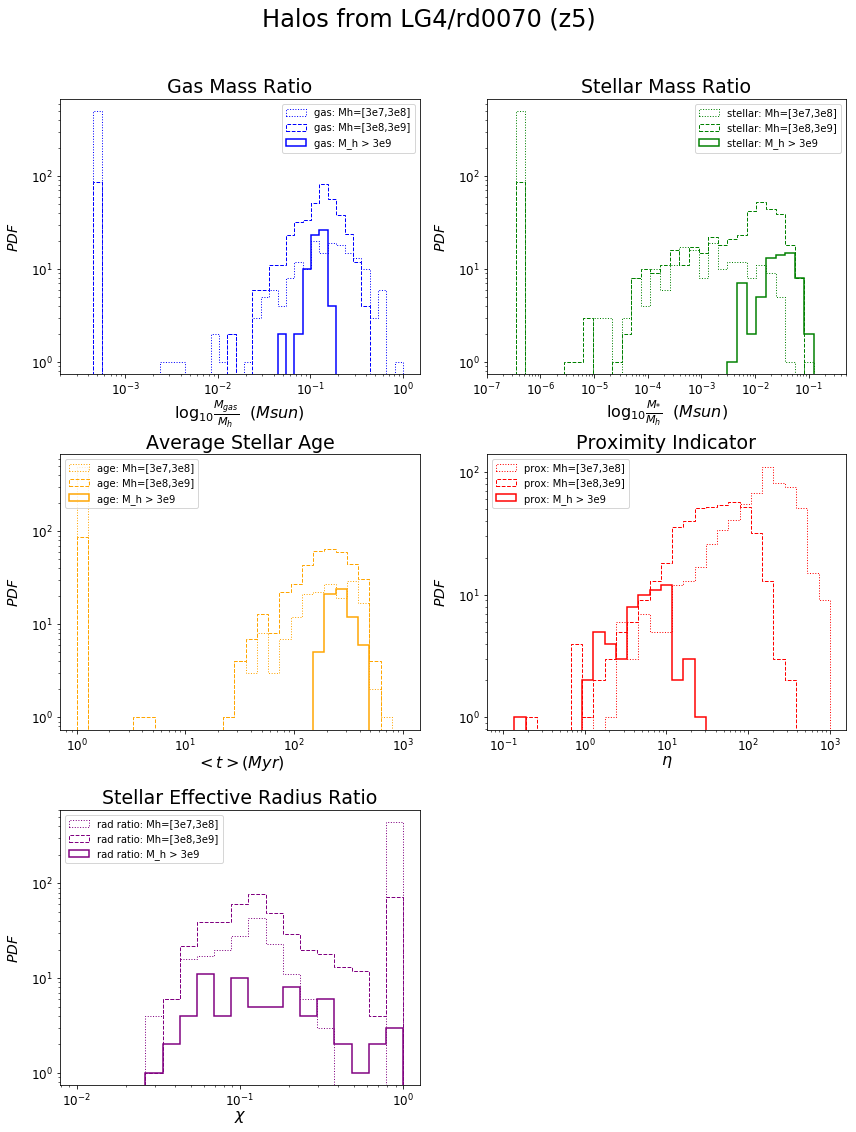

In [270]:
# create subplots
fig1 = plt.figure(figsize = (12,16))
ax1 = plt.subplot(3,2,1)
ax2 = plt.subplot(3,2,2)
ax3 = plt.subplot(3,2,3)
ax4 = plt.subplot(3,2,4)
ax5 = plt.subplot(3,2,5)

# plot titles
figtitle = "Halos from LG4/rd0070 (z5)"
gastitle = "Gas Mass Ratio"
stellartitle = "Stellar Mass Ratio"
agetitle = "Average Stellar Age"
proxtitle = "Proximity Indicator"
radtitle = "Stellar Effective Radius Ratio"

# plot various lists
ratiolists = [ratiolist1, ratiolist2]
ax1.hist(new_ratiolist11, gasbins, ec = 'blue', lw = 1, label = 'gas: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax1.hist(new_ratiolist12, gasbins, ec = 'blue', lw = 1, label = 'gas: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax1.hist(new_ratiolist13, gasbins, ec = 'blue', lw = 1.5, label = 'gas: M_h > 3e9', linestyle = "-", histtype='step', fill = False)
ax2.hist(new_ratiolist21, stelbins, ec = 'green', lw = 1, label = 'stellar: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax2.hist(new_ratiolist22, stelbins, ec = 'green', lw = 1, label = 'stellar: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax2.hist(new_ratiolist23, stelbins, ec = 'green', lw = 1.5, label = 'stellar: M_h > 3e9', linestyle = "-", histtype='step', fill = False)
ax3.hist(ave_agelist1, agebins, ec = 'orange', lw = 1, label = 'age: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax3.hist(ave_agelist2, agebins, ec = 'orange', lw = 1, label = 'age: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax3.hist(ave_agelist3, agebins, ec = 'orange', lw = 1.5, label = 'age: M_h > 3e9', linestyle = "-", histtype='step', fill = False)
ax4.hist(proxlist1, proxbins, ec = 'red', lw = 1, label = 'prox: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax4.hist(proxlist2, proxbins, ec = 'red', lw = 1, label = 'prox: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax4.hist(proxlist3, proxbins, ec = 'red', lw = 1.5, label = 'prox: M_h > 3e9', linestyle = "-", histtype='step', fill = False)
ax5.hist(rad_ratiolist1, radbins, ec = 'purple', lw = 1, label = 'rad ratio: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax5.hist(rad_ratiolist2, radbins, ec = 'purple', lw = 1, label = 'rad ratio: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax5.hist(rad_ratiolist3, radbins, ec = 'purple', lw = 1.5, label = 'rad ratio: M_h > 3e9', linestyle = "-", histtype='step', fill = False)

# set title
plt.suptitle(figtitle, fontsize = 24)
ax1.set_title(gastitle, size = 19)
ax2.set_title(stellartitle, size = 19)
ax3.set_title(agetitle, size = 19)
ax4.set_title(proxtitle, size = 19)
ax5.set_title(radtitle, size = 19)
#ax1.axis([1e-4, 10**1.5, 0, 700])

# create axis labels
gaslab = r"$\log_{10}\frac{M_{gas}}{M_h}$  $(Msun)$"
stellab = r"$\log_{10}\frac{M_{*}}{M_h}$  $(Msun)$"
agelab = r"$<t> (Myr)$"
proxlab = r"$\eta$"
radlab = r"$\chi$"
ylab = "$PDF$"
ax1.set_xlabel(gaslab, size = 16, labelpad= 0)
ax2.set_xlabel(stellab, size = 16, labelpad= 0)
ax3.set_xlabel(agelab, size = 16, labelpad= 0)
ax4.set_xlabel(proxlab, size = 16, labelpad= 0)
ax5.set_xlabel(radlab, size = 16, labelpad= 0)
ax1.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)
ax2.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)
ax3.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)
ax4.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)
ax5.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)

# create axis ticks 
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.tick_params(axis='x', which='major', labelsize=12)
ax1.tick_params(axis='y', which='major', labelsize=12)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.tick_params(axis='x', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.tick_params(axis='x', which='major', labelsize=12)
ax3.tick_params(axis='y', which='major', labelsize=12)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.tick_params(axis='x', which='major', labelsize=12)
ax4.tick_params(axis='y', which='major', labelsize=12)
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.tick_params(axis='x', which='major', labelsize=12)
ax5.tick_params(axis='y', which='major', labelsize=12)


# add labels for each plot
# annotation1 = 'using .sum'
# annotation2 = 'using particle mask'
# ax1.text(start, 20, annotation1, size = 12)
# ax2.text(start, 30, annotation2, size = 12)

# set axis limits
ax2.set_xlim([1e-7, 0.5])

# add legend
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
ax3.legend(loc = 'upper left')
ax4.legend(loc = 'upper left')
ax5.legend(loc = 'upper left')

# adjust spacing and show
plt.tight_layout()
fig1.subplots_adjust(top=0.9)
plt.show()

#plt.savefig('./LG4_2048_40pc/rd0070/massratios.png', dpi = 300)

In [262]:
new_logratio21 = np.log([value for value in new_ratiolist21 if value > 0]) / log(10)
new_logratio22 = np.log([value for value in new_ratiolist22 if value > 0]) / log(10)
new_logratio23 = np.log([value for value in new_ratiolist23 if value > 0]) / log(10)

plot_logratio23 = 2*(60**(new_logratio23 + 2.5))

In [199]:
plot_logratio23

array([  1.50029129e+02,   1.21849045e+02,   4.38910705e+01,
         2.16176031e+02,   9.66568696e+01,   1.17658037e+02,
         2.94250646e+02,   2.19938154e+01,   1.32390945e+01,
         5.71103392e+02,   2.49058990e+02,   2.08982751e+02,
         7.25549222e+02,   2.07898977e+02,   2.72772598e+02,
         8.33371318e+01,   8.37664864e+01,   2.16877163e+02,
         3.82588615e+01,   3.94953648e+02,   2.71694343e+02,
         4.03734351e+01,   1.82186935e+01,   4.19083437e+01,
         2.24100063e+01,   8.03688648e+01,   5.94005302e+01,
         4.87381521e-68,   1.61844011e-67,   1.60145298e+02,
         3.49239542e+01,   8.22582531e+00,   5.60124433e+01,
         1.00657917e+02,   4.73909070e+01,   2.29289831e+02,
         1.12724237e+01,   2.66562481e+01,   8.53527258e+01,
         1.33103243e-67,   3.79210563e+01,   2.16269715e+02,
         9.59134619e+01,   7.18741640e+01,   1.29491860e+02,
         1.55929965e+02,   4.83570398e+01,   2.71731910e+01,
         8.13890838e+01,

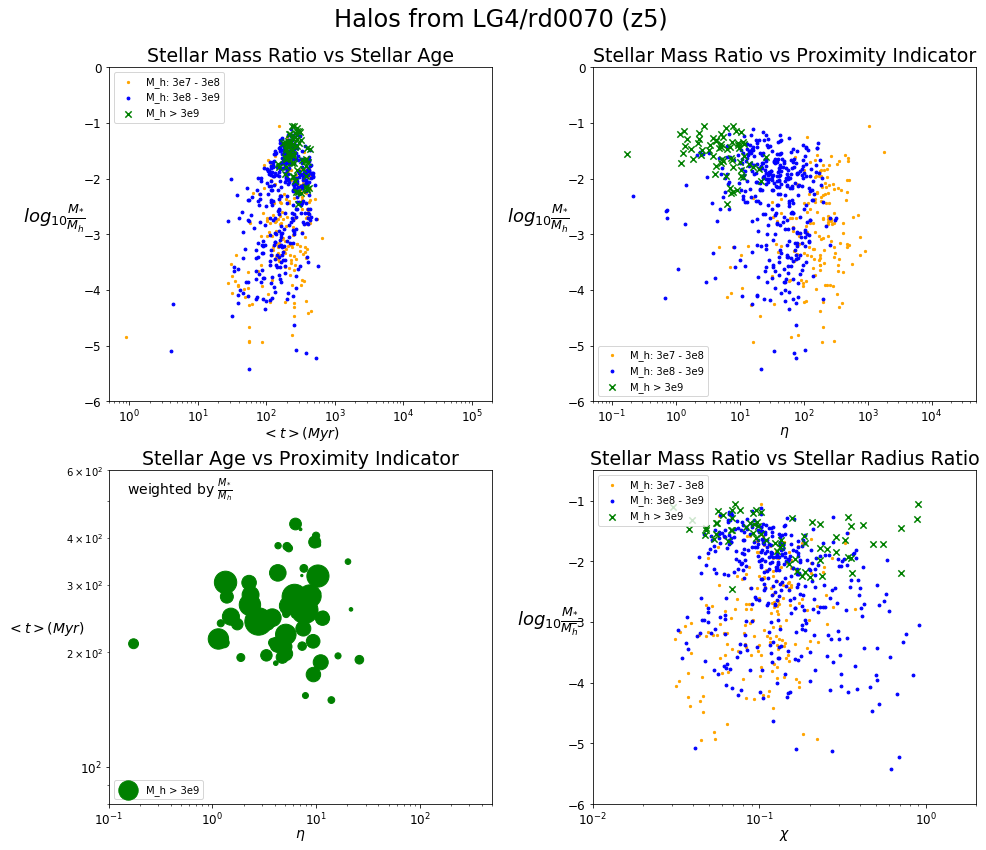

In [278]:
# specify figure size
fig2 = plt.figure(figsize=(14,12))
ax1 = fig2.add_subplot(221)
ax2 = fig2.add_subplot(222)
ax3 = fig2.add_subplot(223)
ax4 = fig2.add_subplot(224)

# create plot titles
agetitle = "Stellar Mass Ratio vs Stellar Age"
proxtitle = "Stellar Mass Ratio vs Proximity Indicator"
ageproxtitle = "Stellar Age vs Proximity Indicator"
radratiotitle = "Stellar Mass Ratio vs Stellar Radius Ratio"

# # --determine line of best fit
# # reduce range of values to fit line
# bin_edges_fit1 = bin_edges1[8:-10]
# bin_edges_fit2 = bin_edges2[16:-4]
# log_density_fit1 = log_density1[7:-10]
# log_density_fit2 = log_density2[15:-4]
# # determine line
# par1 = np.polyfit(bin_edges_fit1, log_density_fit1, 1, full=True)
# par2 = np.polyfit(bin_edges_fit2, log_density_fit2, 1, full=True)
# slope1, intercept1 = par1[0][0], par1[0][1]
# slope2, intercept2 = par2[0][0], par2[0][1]

# plot data 
ax1.scatter(ave_agelist1, new_logratio21, c = 'orange', s = 5, label = 'M_h: 3e7 - 3e8')
ax1.scatter(ave_agelist2, new_logratio22, c = 'blue', s = 8, label = 'M_h: 3e8 - 3e9')
ax1.scatter(ave_agelist3, new_logratio23, c = 'green', s = 40, label = 'M_h > 3e9', marker = 'x')
ax2.scatter(proxlist1, new_logratio21, c = 'orange', s = 5, label = 'M_h: 3e7 - 3e8')
ax2.scatter(proxlist2, new_logratio22, c = 'blue', s = 8, label = 'M_h: 3e8 - 3e9')
ax2.scatter(proxlist3, new_logratio23, c = 'green', s = 40, label = 'M_h > 3e9', marker = 'x')
ax3.scatter(proxlist3, ave_agelist3, c = 'green', s = plot_logratio23, cmap='binary', label = 'M_h > 3e9')
ax4.scatter(rad_ratiolist1, new_logratio21, c = 'orange', s = 5, label = 'M_h: 3e7 - 3e8')
ax4.scatter(rad_ratiolist2, new_logratio22, c = 'blue', s = 8, label = 'M_h: 3e8 - 3e9')
ax4.scatter(rad_ratiolist3, new_logratio23, c = 'green', s = 40, label = 'M_h > 3e9', marker = 'x')
# ax2.plot(bin_edges_red1, slope1 * bin_edges_red1 + intercept1, color = 'red')
# ax2.plot(bin_edges_red2, slope2 * bin_edges_red2 + intercept2, color = 'red')

# set titles
plt.suptitle(figtitle, fontsize = 24)
ax1.set_title(agetitle, size = 19)
ax2.set_title(proxtitle, size = 19)
ax3.set_title(ageproxtitle, size = 19)
ax4.set_title(radratiotitle, size = 19)

# create axis labels
agelab = "$<t> (Myr)$"
proxlab = r"$\eta$"
radlab = r"$\chi$"
ylab = r"$log_{10}\frac{M_{*}}{M_h}$"
ax1.set_xlabel(agelab, size = 14, labelpad= 0)
ax1.set_ylabel(ylab, rotation = 0, size = 18, labelpad= 30)
ax2.set_xlabel(proxlab, size = 14, labelpad= 0)
ax2.set_ylabel(ylab, rotation = 0, size = 18, labelpad= 30)
ax3.set_xlabel(proxlab, size = 14, labelpad= 0)
ax3.set_ylabel(agelab, rotation = 0, size = 14, labelpad= 20)
ax4.set_xlabel(radlab, size = 14, labelpad= 0)
ax4.set_ylabel(ylab, rotation = 0, size = 18, labelpad= 20)

# create axis ticks and set y lim
ax1.set_xscale('log')
ax1.set_xlim([5e-1, 2e5])
ax1.set_ylim([-6, 0])
ax1.tick_params(axis='x', which='major', labelsize=12)
ax1.tick_params(axis='y', which='major', labelsize=12)
ax2.set_xscale('log')
ax2.set_xlim([5e-2, 5e4])
ax2.set_ylim([-6, 0])
ax2.tick_params(axis='x', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim([1e-1,5e2])
ax3.set_ylim([8e1,6e2])
ax3.tick_params(axis='x', which='major', labelsize=12)
ax3.tick_params(axis='y', which='major', labelsize=12)
ax4.set_xscale('log')
ax4.set_xlim([1e-2, 2e0])
ax4.set_ylim([-6, -0.5])
ax4.tick_params(axis='x', which='major', labelsize=12)
ax4.tick_params(axis='y', which='major', labelsize=12)

# add annotation
annotation = r"weighted by $\frac{M_{*}}{M_h}$"
ax3.text(1.5e-1, 5.2e2, annotation, size = 14)

# add legend
ax1.legend(loc = 'upper left')
ax2.legend(loc = 'lower left')
ax3.legend(loc = 'lower left')
ax4.legend(loc = 'upper left')

# adjust spacing and show
plt.tight_layout()
fig2.subplots_adjust(top=0.91)
plt.show()

In [124]:
# find log arrays for ratio lists
log_ratio1 = np.log(ratiolist1) / log(10)
log_ratio2 = np.log([value for value in ratiolist2 if value > 0]) / log(10)

# find histogram parameters
density1, bin_edges1 = np.histogram(log_ratio1, bins= np.linspace(-3.5, 0.4, 39))
density2, bin_edges2 = np.histogram(log_ratio2, bins= np.linspace(-2.2, 1.1, 33))


log_density1 = np.log(density1) / log(10)
log_density2 = np.log(density2) / log(10)

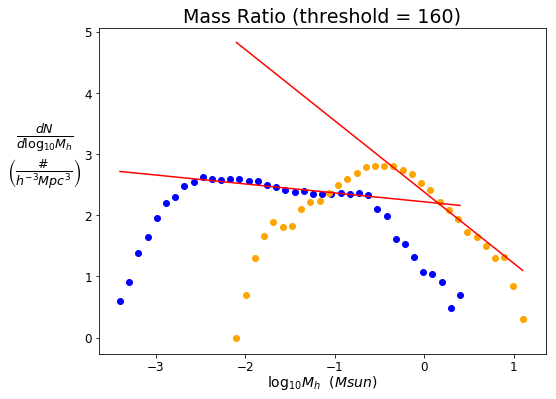

In [161]:
# specify figure size
fig2 = plt.figure(figsize=(8,6))
ax2 = fig2.add_subplot(111)

# --determine line of best fit
# reduce range of values to fit line
bin_edges_fit1 = bin_edges1[8:-10]
bin_edges_fit2 = bin_edges2[16:-4]
log_density_fit1 = log_density1[7:-10]
log_density_fit2 = log_density2[15:-4]
# determine line
par1 = np.polyfit(bin_edges_fit1, log_density_fit1, 1, full=True)
par2 = np.polyfit(bin_edges_fit2, log_density_fit2, 1, full=True)
slope1, intercept1 = par1[0][0], par1[0][1]
slope2, intercept2 = par2[0][0], par2[0][1]

# plot data and line
bin_edges_red1 = bin_edges1[1:]
bin_edges_red2 = bin_edges2[1:]
ax2.scatter(bin_edges_red1, log_density1, color = 'blue')
ax2.scatter(bin_edges_red2, log_density2, color = 'orange')
ax2.plot(bin_edges_red1, slope1 * bin_edges_red1 + intercept1, color = 'red')
ax2.plot(bin_edges_red2, slope2 * bin_edges_red2 + intercept2, color = 'red')
ax2.set_title("Mass Ratio (threshold = 160)", size = 19)

# create axis labels
xlab = "$\log_{10}M_h}$  $(Msun)$"
ylab = r"$\frac{dN}{d\log_{10}M_h}$"+"\n"+r"$\left(\frac{\#}{h^{-3}Mpc^3}\right)$"
ax2.set_xlabel(xlab, size = 14, labelpad= 0)
ax2.set_ylabel(ylab, rotation = 0, size = 18, labelpad= 40)

# create axis ticks 
ax2.set_yscale('linear')
ax2.tick_params(axis='x', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12)

# add slope and intercept
# annotation = "$a = {:1.3f}$ \n$b = {:1.3f}$".format(slope, intercept)
# plt.text(9.5, 1.5, annotation, size = 12)

#show and save
plt.show()

27


27